In [7]:
%matplotlib inline
import os
import bvhsdk
import numpy as np
import pickle
import librosa
import scipy.io.wavfile as wav
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch

DBPATH = 'E:\\GestureDataset\\'
MOTIONPATH = os.path.join(DBPATH, 'motion')
BVHPATH = os.path.join(MOTIONPATH, 'bvh')
M_NPYPATH = os.path.join(MOTIONPATH, 'npy')

AUDIOPATH = os.path.join(DBPATH, 'audio')
WAVPATH = os.path.join(AUDIOPATH, 'wav')
A_NPYPATH = os.path.join(AUDIOPATH, 'npy')
#JOINTS = ['RightArm', 'RightForeArm', 'RightHand', 'LeftArm', 'LeftForeArm', 'LeftHand']

In [8]:
class GestData(Dataset):
    def __init__(self, fps=30, window=120, overlap=60):
        self.window=window
        self.overlap=overlap

        motionfiles = os.listdir(M_NPYPATH)
        audiofiles = os.listdir(A_NPYPATH)
        motionfiles = [file for file in motionfiles if file[-4:]==".npy"]
        motionfiles.sort()
        audiofiles.sort()
        # Check the number of wav and npy files
        assert len(motionfiles) == len(audiofiles)
        self.takes = []
        # Creates a take for each pair of file
        for motionfile, audiofile in zip(motionfiles, audiofiles):
            assert motionfile.split('.')[0] == audiofile.split('.')[0]
            samp = Take(motionfile, audiofile)
            self.takes.append(samp)

        with open(os.path.join(M_NPYPATH, 'joints'), 'rb') as f:
            self.jointnames = pickle.load(f)

        self.joint = {k+s:v*6+j for v,k in enumerate(self.jointnames) for j,s in enumerate(["_rx", "_ry", "_rz", "_tx", "_ty", "_tz"])}
        #self.createLabels()
        #self.maxs, self.mins = self.get_maxmin()
        #self.feature_scaling()
        #self.prepare_samples2()

    def __getitem__old(self, index):
        take, index = self.index2take(index)
        sample_range = self.samples_index_per_take[take][index]
        return self.takes[take].motion.data[sample_range[0]:sample_range[1],:], self.takes[take].takelabel

    def __getitem__(self, index):
        return self.input[index], self.label[index]

    def __len__(self):
        #return self.samples_per_take_acc[-1]
        return self.input.shape[0]

    def index2take(self, index):
        found = False
        take = 0
        while not found:
            if self.samples_per_take[take] > index:
                found = True
            else:
                index -= self.samples_per_take[take]
                take += 1
        return take, index #return take and index inside the take

    def prepare_samples2(self):
        #totalframes = np.asarray([take.motion.data.shape[0] for take in self.takes]).sum()
        #self.input = np.zeros(shape=(totalframes, 360))
        #aux = 0
        #for take in self.takes:
        #    print(take.ref, aux, take.motion.data.shape)
        #    self.input[ aux : take.motion.data.shape[0] + aux , :] = take.motion.data
        #    aux += take.motion.data.shape[0]
        #self.input = torch.as_tensor(self.input, dtype=torch.double)
        self.prepare_samples()
        total_samples = self.samples_per_take_acc[-1]
        self.input = np.zeros(shape=(total_samples, self.window, 360))
        self.label = np.zeros(shape=(total_samples, 6))
        for i in range(total_samples):
            take, index = self.index2take(i)
            sample_range = self.samples_index_per_take[take][index]
            self.input[ i, :, :] = self.takes[take].motion.data[sample_range[0]:sample_range[1],:]
            self.label[i] = self.takes[take].takelabel
        self.input = torch.as_tensor(self.input, dtype=torch.float)
        self.label = torch.as_tensor(self.label, dtype=torch.float)


    def prepare_samples(self):
        # Get how many frames each take has
        #self.frameslist = [take.motion.data.shape[0] for take in self.takes if take.takelabel]
        self.frameslist = [take.motion.data.shape[0] for take in self.takes]
        # Get index of each sample for each take
        self.samples_index_per_take = []
        for frames_in_take in self.frameslist:
            self.samples_index_per_take.append( [(i-self.window, i) for i in np.arange(self.window, frames_in_take, self.window-self.overlap)] )
        # Samples per take
        self.samples_per_take = [len(i) for i in self.samples_index_per_take]
        # Get samples per take cumulative
        self.samples_per_take_acc = [ np.sum(self.samples_per_take[:i+1]) for i in np.arange(len(self.samples_per_take))]


    def feature_scaling(self):
        for take in self.takes:
            take.motion.data = np.nan_to_num((take.motion.data - self.mins) / (self.maxs - self.mins), nan=0.0, copy=False)


    def get_maxmin(self):
        maxs = np.zeros(360)-np.inf
        mins = np.zeros(360)+np.inf
        for take in self.takes:
            aux_max = np.max(take.motion.data, axis=0)
            aux_min = np.min(take.motion.data, axis=0)
            maxs = np.maximum(maxs, aux_max)
            mins = np.minimum(mins, aux_min)

        return maxs, mins

    def compute_relative_positions(self):
        # Compute the position of each joint relative to the hips
        positions_indexes = [i+j*6 for j,_ in enumerate(range(60)) for i in [3,4,5]]
        hips_centric_indexes = positions_indexes[:36] + positions_indexes[90:102] + positions_indexes[156:]
        rhand_centric_indexes = positions_indexes[36:90]
        lhand_centric_indexes = positions_indexes[102:156]

        for take in self.takes:
            for i in range(3,len(hips_centric_indexes), 3):
                take.motion.data[:,hips_centric_indexes[i:i+3]] = take.motion.data[:,hips_centric_indexes[i:i+3]] - take.motion.data[:,3:6]
            for i in range(3,len(rhand_centric_indexes), 3):
                take.motion.data[:,rhand_centric_indexes[i:i+3]] = take.motion.data[:,rhand_centric_indexes[i:i+3]] - take.motion.data[:,69:72]
            for i in range(3,len(lhand_centric_indexes), 3):
                take.motion.data[:,lhand_centric_indexes[i:i+3]] = take.motion.data[:,lhand_centric_indexes[i:i+3]] - take.motion.data[:,201:204]


    def createLabels(self):
        for take in self.getId(1):
            if take.p==1:
                if take.e==1:
                    take.takelabel = [1,0,0,0,0,0]
                elif take.e==2:
                    take.takelabel = [0,1,0,0,0,0]
                elif take.e==3:
                    take.takelabel = [0,0,1,0,0,0]
        for take in self.getId(2):
            if take.p==1:
                if take.e==1:
                    take.takelabel = [0,0,0,1,0,0]
                elif take.e==2:
                    take.takelabel = [0,0,0,0,1,0]
                elif take.e==3:
                    take.takelabel = [0,0,0,0,0,1]
        # Remove takes without labels
        self.takes = [take for take in self.takes if take.takelabel]


    def getTake(self, name):
        info = name.split('_')
        try:
            info_id, info_p, info_e, info_f = int(info[0][2:]), int(info[1][1:]), int(info[2][1:]), int(info[3][1:])
        except:
            print("Please use the format \"idxx_pxx_exx_fxx\".")
        for take in self.takes:
            if take.id == info_id:
                if take.p == info_p:
                    if take.e == info_e:
                        if take.f == info_f:
                            return take

    def getId(self, info_id):
        assert type(info_id)==int
        for take in self.takes:
            if take.id == info_id:
                yield take

    def getPart(self, info_p, info_id=None):
        if info_id:
            assert type(info_id)==int and type(info_p)==int
            for take in self.takes:
                if take.id == info_id and take.p == info_p:
                    yield take
        else:
            assert type(info_p)==int
            for take in self.takes:
                if take.p == info_p:
                    yield take


    def getStyle(self, info_id, info_p, info_e):
        assert type(info_id)==int and type(info_p)==int and type(info_e)==int
        for take in self.takes:
            if take.id == info_id:
                if take.p == info_p:
                    if take.e == info_e:
                        yield take

class Take:
    def __init__(self, motionname, audioname):
        # Get name
        self.ref = motionname.split('.')[0]
        # Get info from name
        self._register()
        # Get data
        self.audio = Audio(os.path.join(A_NPYPATH, audioname), self)
        self.motion = Motion(os.path.join(M_NPYPATH, motionname), self)
        self.takelabel=None


    def _register(self):
        info = self.ref.split('_')
        self.id, self.p, self.e, self.f = int(info[0][2:]), int(info[1][1:]), int(info[2][1:]), int(info[3][1:])
        self.detail()

    def detail(self):
        print("id{:02} p{:02} e{:02} f{:02}".format(self.id, self.p, self.e, self.f))

class Audio:
    def __init__(self, path, take):
        self.path = path
        self.data = np.load(self.path)
        self.take = take

class Motion:
    def __init__(self, path, take):
        self.path = path
        self.data = np.load(self.path)
        self.take = take

def bvh2npyconverter(overwrite = False):
    npypath = os.path.join(MOTIONPATH, 'npy')
    # Creates a path to npy files inside the dataset file
    # if overwrite = False look for a available dir such as "npy_3"
    # if overwrite = True simply choose dir "npy"
    if os.path.exists(npypath):
        if not overwrite:
            i = 2
            while os.path.exists(npypath+'_'+str(i)):
                i += 1
            npypath = npypath+'_'+str(i)
            os.makedirs(npypath)
    else:
        os.makedirs(npypath)

    bvhfiles = os.listdir(BVHPATH)
    bvhfiles.sort()
    for bvhfile in bvhfiles:
        anim = bvhsdk.ReadFile(os.path.join(BVHPATH, bvhfile))
        npyfile = np.empty(shape=(anim.frames, 6*len(anim.getlistofjoints())))
        for i, joint in enumerate(anim.getlistofjoints()):
            npyfile[:, i*6:i*6+3] = joint.rotation
            for frame in range(anim.frames):
                npyfile[frame, i*6+3:i*6+6] = joint.getPosition(frame)

        np.save(os.path.join(npypath, bvhfile)[:-4], npyfile)
        print('%s done.' % bvhfile)


    #Save joint names (of the last bvh file)
    joint_names = []
    for joint in anim.getlistofjoints():
        joint_names.append(joint.name)
    with open(os.path.join(npypath, "joints"), "wb") as j:
        pickle.dump(joint_names, j)

def wav2npyconverter(overwrite = False, fps=120):
    npypath = os.path.join(AUDIOPATH, 'npy')
    # Creates a path to npy files inside the dataset file
    # if overwrite = False look for a available dir such as "npy_3"
    # if overwrite = True simply choose dir "npy"
    if os.path.exists(npypath):
        if not overwrite:
            i = 2
            while os.path.exists(npypath+'_'+str(i)):
                i += 1
            npypath = npypath+'_'+str(i)
            os.makedirs(npypath)
    else:
        os.makedirs(npypath)

    wavfiles = os.listdir(WAVPATH)
    wavfiles.sort()
    for wavfile in wavfiles:
        print(wavfile)
        fs,signal = wav.read(os.path.join(WAVPATH, wavfile))
        signal_ = signal.astype(float)/math.pow(2,15)
        assert fs%fps == 0
        hop_len=int(fs/fps)
        n_fft=int(fs*0.13)
        C = librosa.feature.melspectrogram(y=signal_, sr=fs, n_fft=2048, hop_length=hop_len, n_mels=27, fmin=0.0, fmax=8000)
        np.save(os.path.join(npypath, wavfile)[:-4], C)


In [9]:
dataset = GestData()

id01 p01 e01 f01
id01 p01 e01 f02
id01 p01 e01 f03
id01 p01 e01 f04
id01 p01 e01 f05
id01 p01 e01 f06
id01 p01 e01 f07
id01 p01 e01 f08
id01 p01 e01 f09
id01 p01 e01 f10
id01 p01 e01 f11
id01 p01 e01 f12
id01 p01 e01 f13
id01 p01 e01 f14
id01 p01 e01 f15
id01 p01 e01 f16
id01 p01 e01 f17
id01 p01 e01 f18
id01 p01 e01 f19
id01 p01 e01 f20
id01 p01 e01 f21
id01 p01 e01 f22
id01 p01 e01 f23
id01 p01 e01 f24
id01 p01 e01 f25
id01 p01 e01 f26
id01 p01 e01 f27
id01 p01 e01 f28
id01 p01 e01 f29
id01 p01 e01 f30
id01 p01 e01 f31
id01 p01 e01 f32
id01 p01 e01 f33
id01 p01 e01 f34
id01 p01 e01 f35
id01 p01 e01 f36
id01 p01 e01 f37
id01 p01 e01 f38
id01 p01 e01 f39
id01 p01 e01 f40
id01 p01 e01 f41
id01 p01 e01 f42
id01 p01 e01 f43
id01 p01 e01 f44
id01 p01 e01 f45
id01 p01 e02 f01
id01 p01 e02 f02
id01 p01 e02 f03
id01 p01 e02 f04
id01 p01 e02 f05
id01 p01 e02 f06
id01 p01 e02 f07
id01 p01 e02 f08
id01 p01 e02 f09
id01 p01 e02 f10
id01 p01 e02 f11
id01 p01 e02 f12
id01 p01 e02 f13
id01 p01 e02 f

id02 p01 e03 f40
id02 p01 e03 f41
id02 p01 e03 f42
id02 p01 e03 f43
id02 p01 e03 f44
id02 p01 e03 f45
id02 p02 e01 f00
id02 p02 e01 f01
id02 p02 e01 f02
id02 p02 e01 f03
id02 p02 e01 f04
id02 p02 e01 f05
id02 p02 e01 f06
id02 p02 e01 f07
id02 p02 e01 f08
id02 p02 e01 f09
id02 p02 e01 f10
id02 p02 e01 f11
id02 p02 e01 f12
id02 p02 e01 f13
id02 p02 e01 f14
id02 p02 e01 f15
id02 p02 e01 f16
id02 p02 e01 f17
id02 p02 e01 f18
id02 p02 e01 f19
id02 p02 e01 f20
id02 p02 e01 f21
id02 p02 e01 f22
id02 p02 e01 f23
id02 p02 e01 f24
id02 p02 e01 f25
id02 p02 e01 f26
id02 p02 e01 f27
id02 p02 e01 f28
id02 p02 e01 f29
id02 p02 e01 f30
id02 p02 e01 f31
id02 p02 e01 f32
id02 p02 e01 f33
id02 p02 e01 f34
id02 p02 e01 f35
id02 p02 e01 f36
id02 p02 e01 f37
id02 p02 e01 f38
id02 p02 e01 f39
id02 p02 e01 f40
id02 p02 e01 f41
id02 p02 e01 f42
id02 p02 e01 f43
id02 p02 e01 f44
id02 p02 e01 f45
id02 p02 e01 f46
id02 p02 e01 f47
id02 p02 e01 f48
id02 p02 e01 f49
id02 p02 e01 f50
id02 p02 e01 f51
id02 p02 e01 f

In [14]:
def __compute_positions(takedata):
    i_trans = [i+j*6 for j,_ in enumerate(range(60)) for i in [3,4,5]]
    i_rots = [i+j*6 for j,_ in enumerate(range(60)) for i in [0,1,2]]
    trans = takedata[:,i_trans]
    rots = takedata[:,i_rots]
    pos = np.zeros(shape=(trans.shape[0], int(trans.shape[1]/3)))
    for i in range(0, trans.shape[1], 3):
        pos[:,int(i/3)] = ( np.sqrt( trans[:,i]**2 + trans[:,i+1]**2 + trans[:,i+2]**2) )
        
    return pos, rots
    

def compute_means_positions(data, _id = 1, _part = 1, vel=False):
    to_plot_pos = []
    to_plot_rots = []
    for _style in [1,2,3]:
        means_pos = []
        means_rots = []
        frames = []
        for i, sample in enumerate(data.getStyle(_id, _part, _style)):
            pos, rots = __compute_positions( sample.motion.data )
            if vel:
                pos = pos[1:,:] - pos[:-1,:]
                rots = rots[1:,:] - rots[:-1,:]
            
            means_pos.append( np.mean(pos, axis=0) )
            means_rots.append( np.mean(rots, axis=0) )
            frames.append( sample.motion.data.shape[0] )
        means_pos = np.asarray(means_pos)
        means_rots = np.asarray(means_rots)
        
        frames = np.asarray(frames)
        
        means_aux_pos = np.asarray([ means_pos[i, :]*frames[i] for i in range(frames.shape[0]) ])
        means_aux_pos = np.sum(means_aux_pos, axis=0)
        means_aux_pos = means_aux_pos/ np.sum(frames)
        
        means_aux_rots = np.asarray([ means_rots[i, :]*frames[i] for i in range(frames.shape[0]) ])
        means_aux_rots = np.sum(means_aux_rots, axis=0)
        means_aux_rots = means_aux_rots/ np.sum(frames)
        
        to_plot_pos.append(means_aux_pos)
        to_plot_rots.append(means_aux_rots)
    #means = (takes, joints)
    #frames = (takes,)
    return to_plot_pos, to_plot_rots

def compute_vel_means(data, _id = 1, _part = 1):
    #for i, joint in enumerate(data.joints):
    #    print(i, joint)
    #focus_joints = [0,1,2,3,4,5,6,7,8,9,10,11,30,31,32,33,52,53,54,55,56,57,58,59]
    to_plot = []
    for _style in [1,2,3]:
        means = []
        frames = []
        for i, sample in enumerate(data.getStyle(_id, _part, _style)):
            means.append( np.mean( sample.motion.data[1:,:] - sample.motion.data[:-1,:] , axis=0) )
            frames.append( sample.motion.data.shape[0]-1 )   
        means = np.asarray(means)
        frames = np.asarray(frames)
        means_aux = np.asarray([ means[i, :]*frames[i] for i in range(frames.shape[0]) ])
        means_aux = np.sum(means_aux, axis=0)
        means_aux = means_aux/ np.sum(frames)
        to_plot.append(means_aux)
    #means = (takes, joints)
    #frames = (takes,)
    return to_plot

def separate(raw_array):
    pos = [i+j*6 for j,_ in enumerate(range(60)) for i in [3,4,5]]
    rots = [i+j*6 for j,_ in enumerate(range(60)) for i in [0,1,2]]
    return raw_array[pos], raw_array[rots]

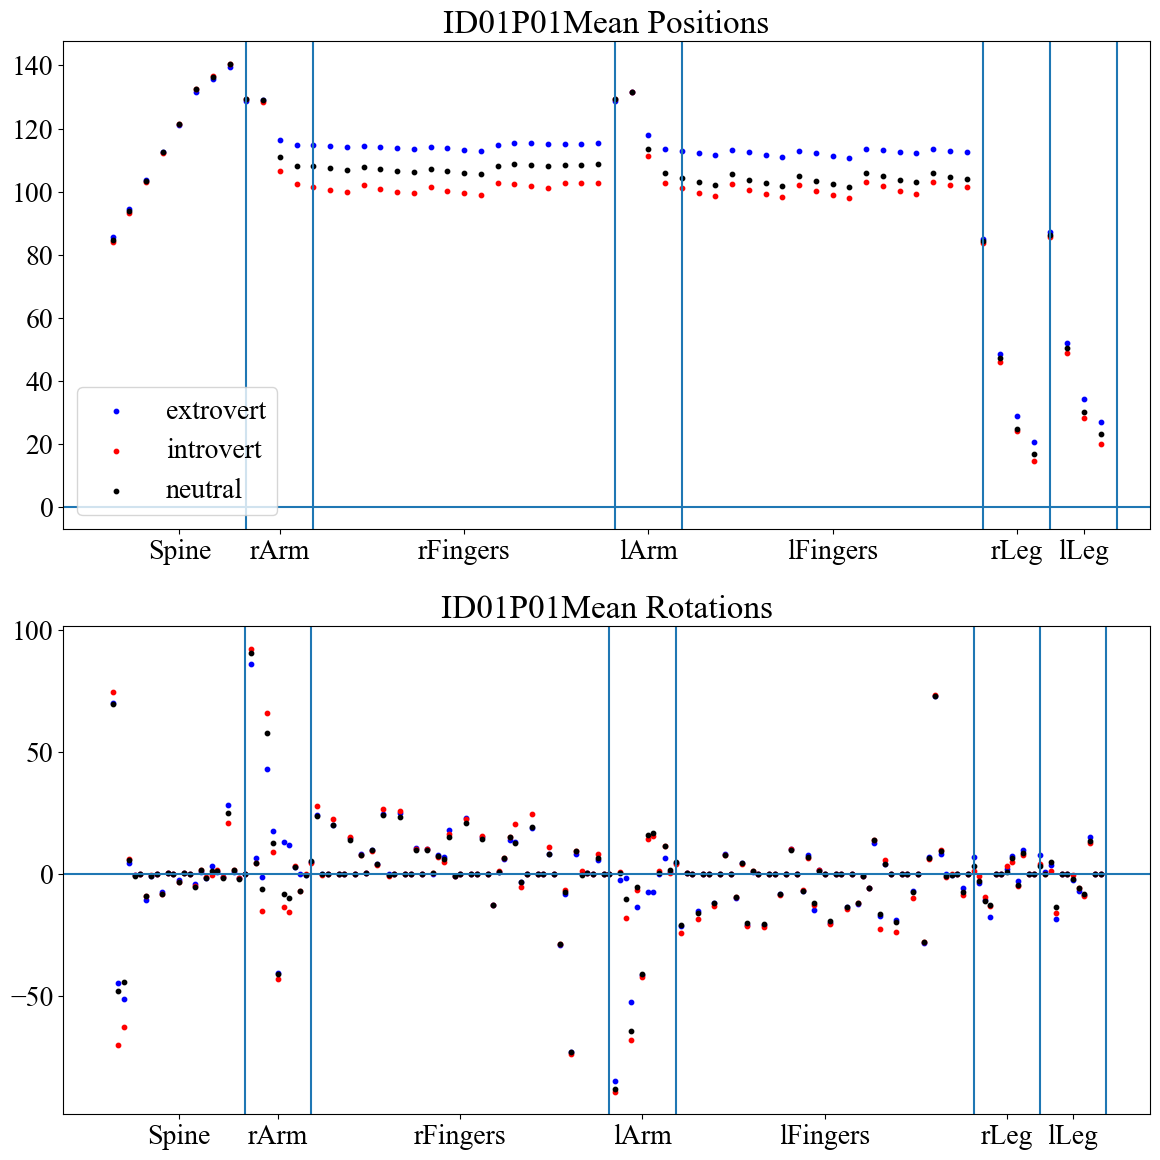

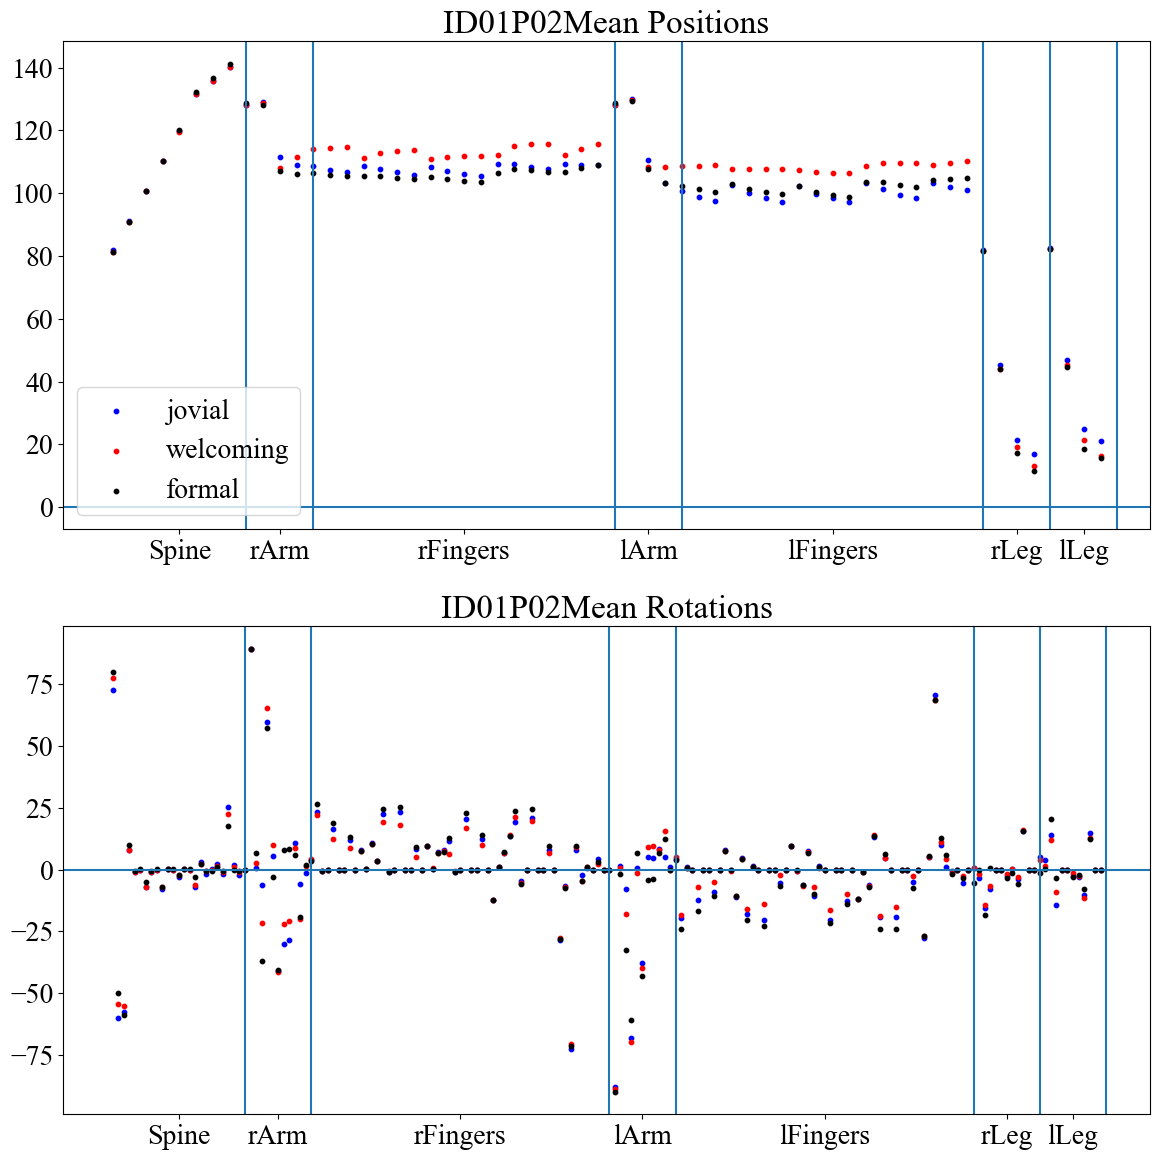

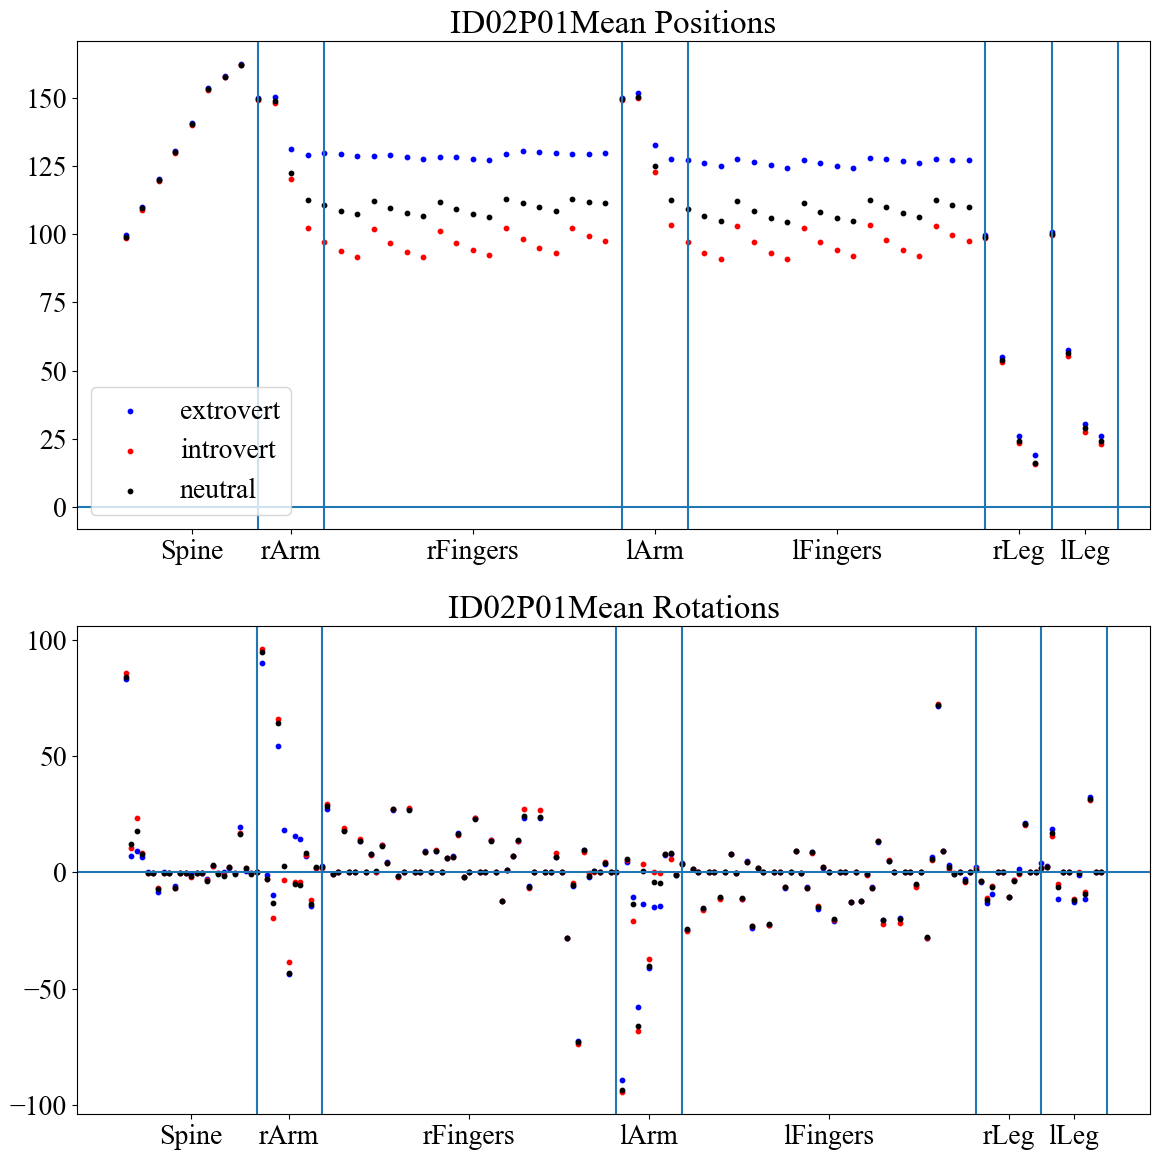

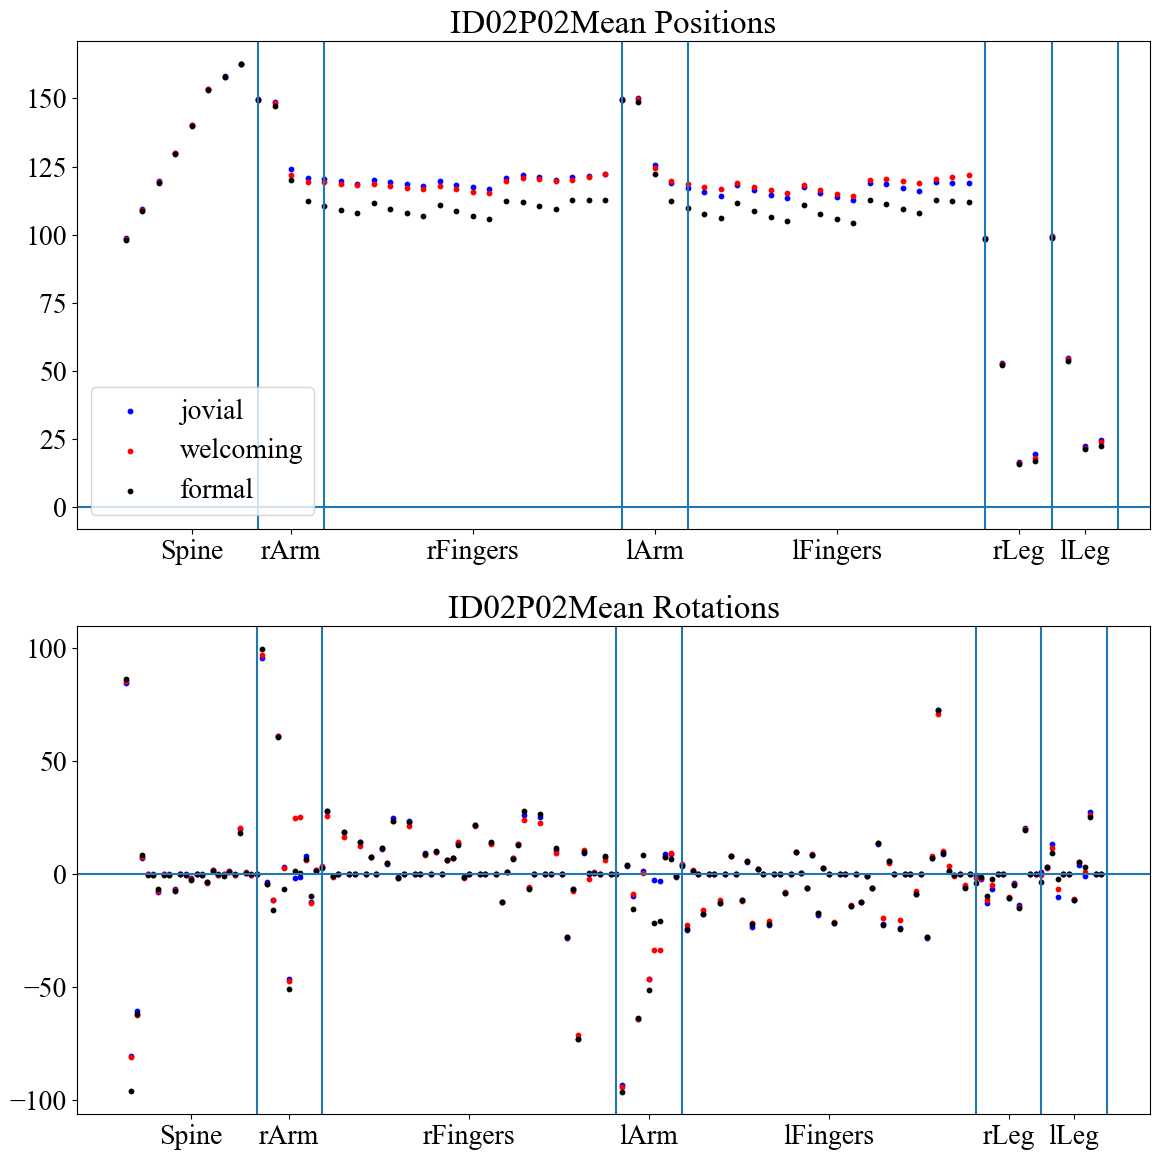

In [13]:
%matplotlib inline
for i, (id, part) in enumerate([[1,1],[1,2],[2,1],[2,2]]):
    title = 'ID0' + str(id) + 'P0' + str(part)
    if part==1:
        labels = ['extrovert', 'introvert', 'neutral']
    else:
        labels = ['jovial', 'welcoming', 'formal']
    
    to_plot_pos, to_plot_rots = compute_means_positions(dataset, id,part)
    pos1, rot1 = to_plot_pos[0], to_plot_rots[0]
    pos2, rot2 = to_plot_pos[1], to_plot_rots[1]
    pos3, rot3 = to_plot_pos[2], to_plot_rots[2]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
    
    ax1.set_title(title + "Mean Positions")
    ax1.scatter(np.arange(len(pos1)), pos1, s = 10, c = 'blue', label=labels[0])
    ax1.scatter(np.arange(len(pos2)), pos2, s = 10, c = 'red', label=labels[1])
    ax1.scatter(np.arange(len(pos3)), pos3, s = 10, c = 'black', label=labels[2])

    ax2.set_title(title + "Mean Rotations")
    ax2.scatter(np.arange(len(rot1)), rot1, s = 10, c = 'blue', label=labels[0])
    ax2.scatter(np.arange(len(rot2)), rot2, s = 10, c = 'red', label=labels[1])
    ax2.scatter(np.arange(len(rot3)), rot3, s = 10, c = 'black', label=labels[2])

    i = np.array([48,72,180,204,312,336,360])/2
    labels_xticks = np.array([i[0]/2, i[0]+(i[1]-i[0])/2, i[1]+(i[2]-i[1])/2, i[2]+(i[3]-i[2])/2, i[3]+(i[4]-i[3])/2, i[4]+(i[5]-i[4])/2, i[5]+(i[6]-i[5])/2])
    labels_name = ["Spine", "rArm", "rFingers", "lArm", "lFingers","rLeg","lLeg"]
    for idx in i:
        ax1.axvline(idx/3)
    ax1.axhline(0)
    ax1.set_xticks(labels_xticks/3, labels = labels_name)

    for idx in i:
        ax2.axvline(idx)
    ax2.axhline(0)
    ax2.set_xticks(labels_xticks, labels = labels_name)

    ax1.legend()
    plt.tight_layout()

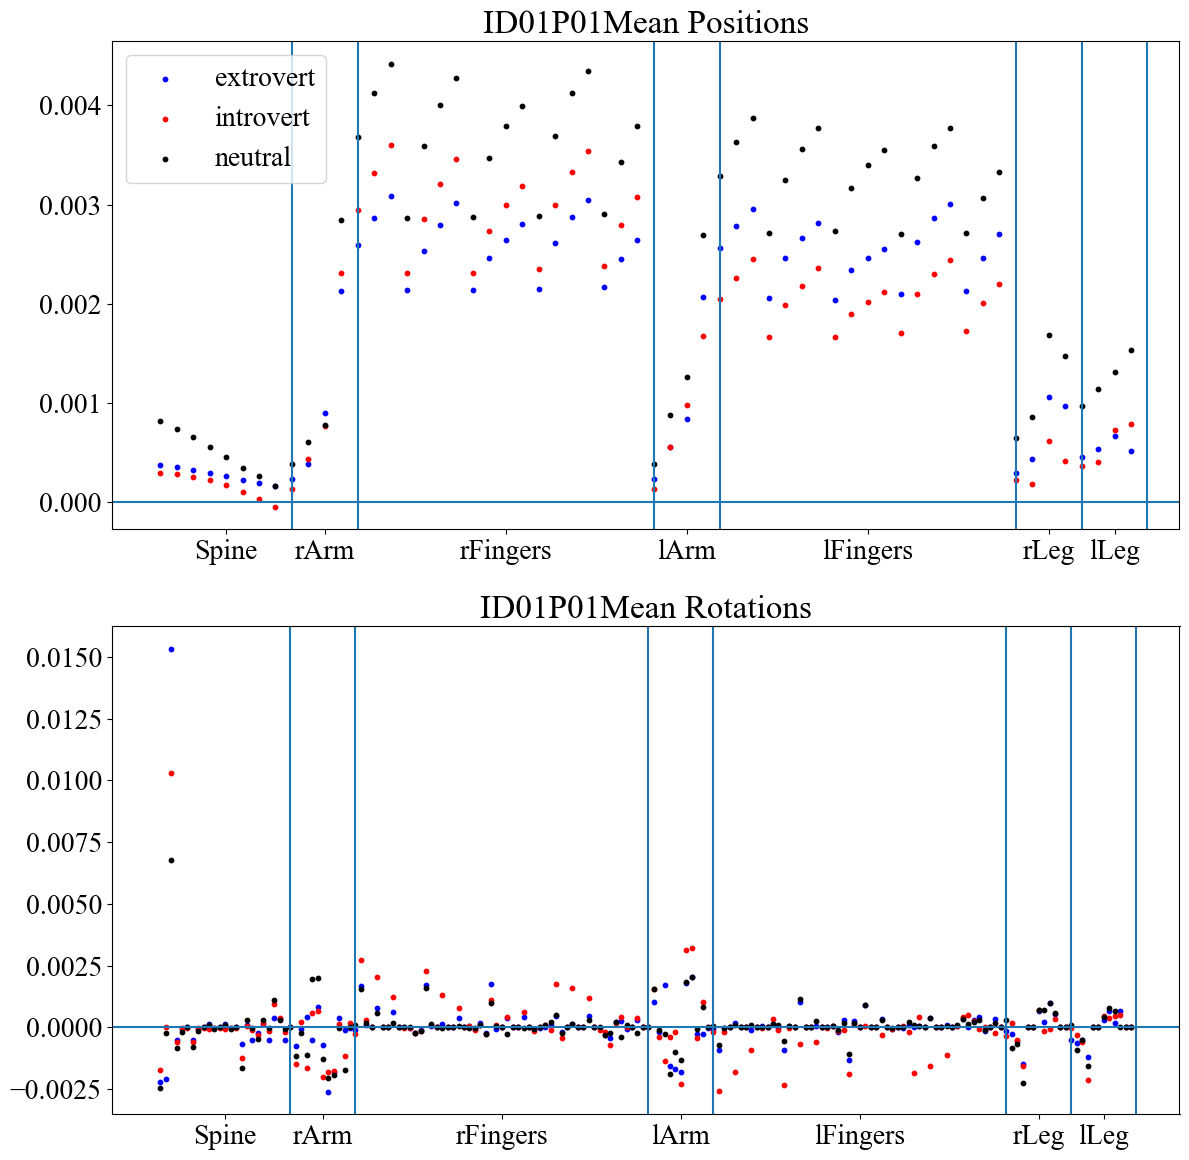

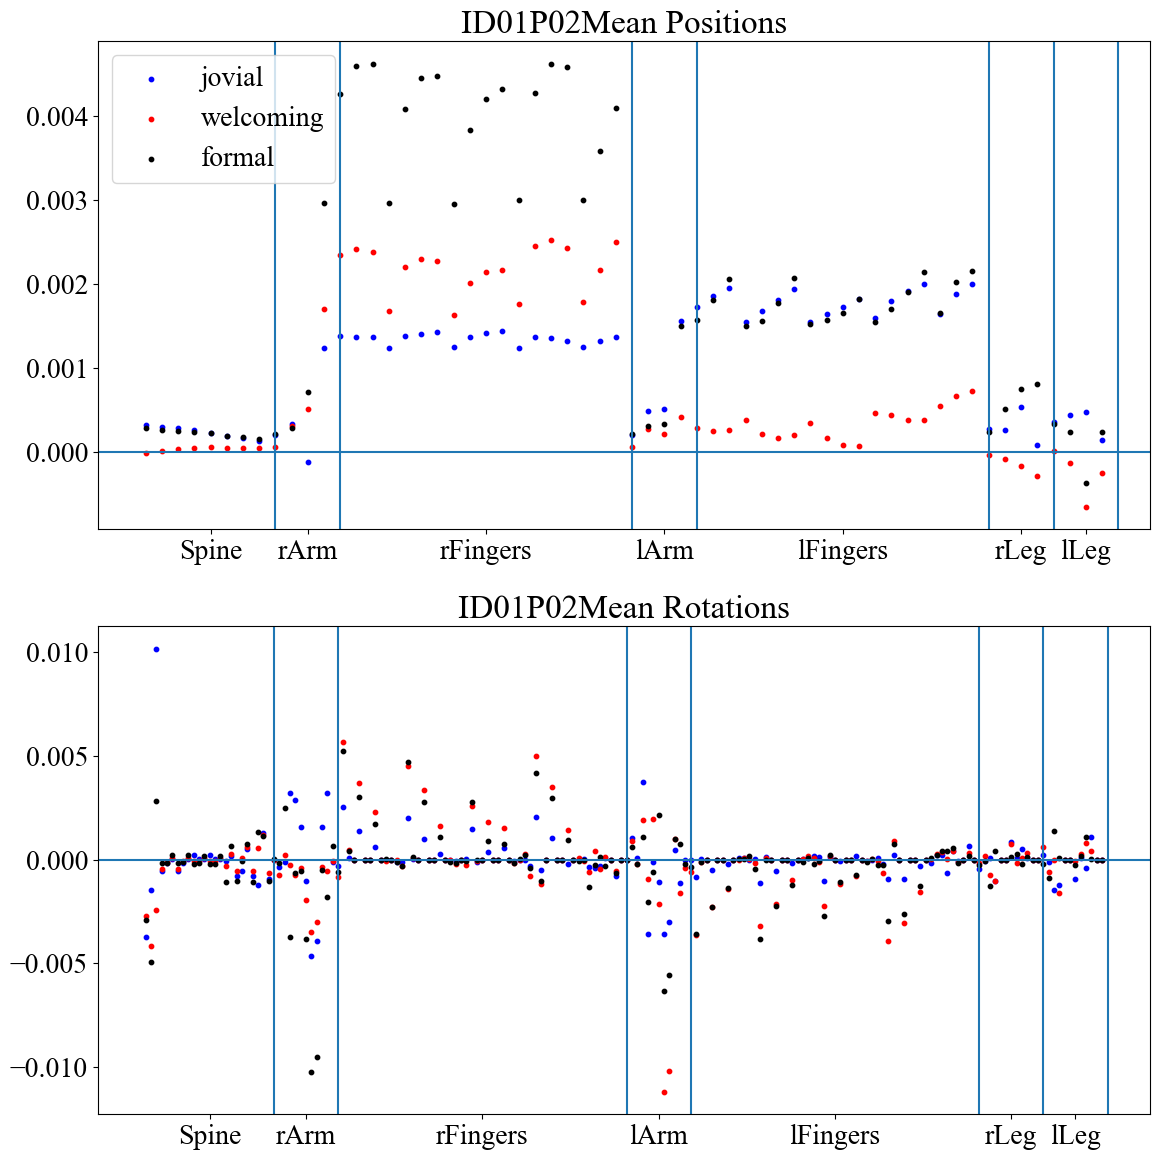

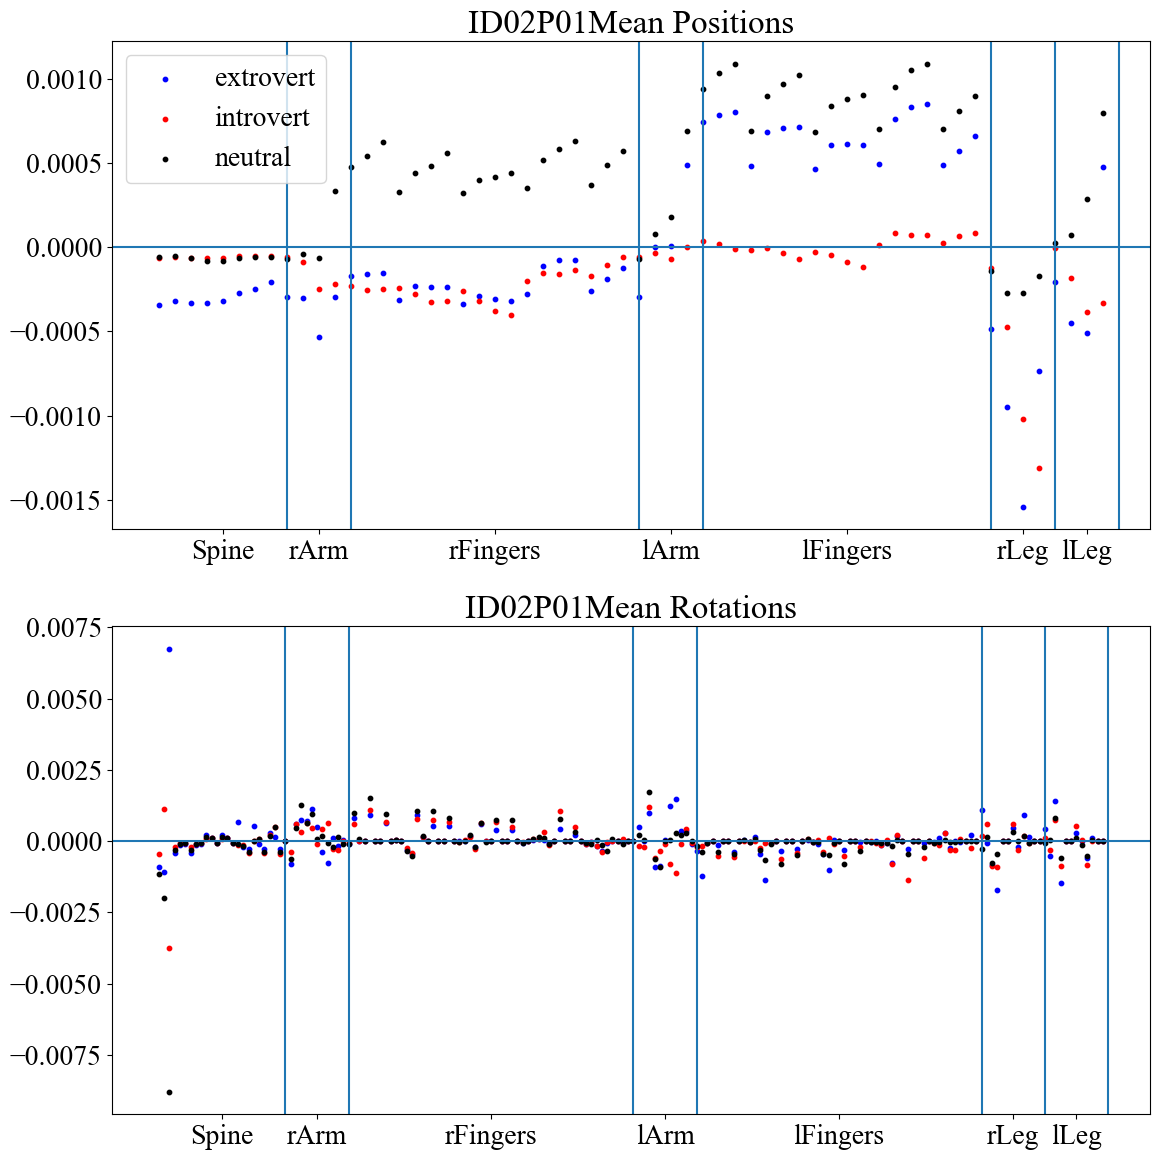

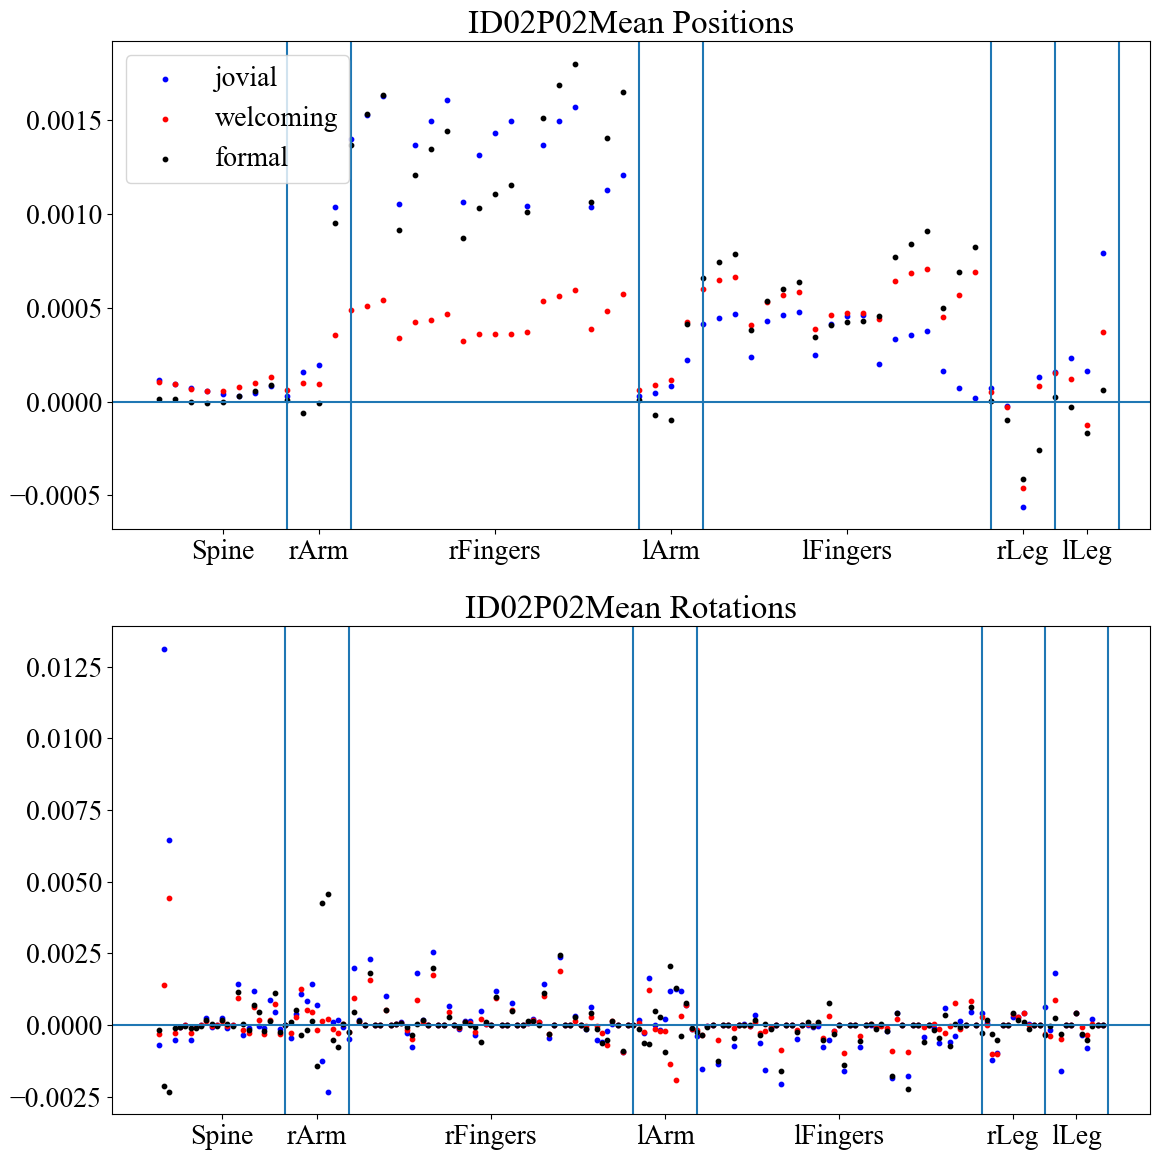

In [15]:
%matplotlib inline
for i, (id, part) in enumerate([[1,1],[1,2],[2,1],[2,2]]):
    title = 'ID0' + str(id) + 'P0' + str(part)
    if part==1:
        labels = ['extrovert', 'introvert', 'neutral']
    else:
        labels = ['jovial', 'welcoming', 'formal']
    
    to_plot_pos, to_plot_rots = compute_means_positions(dataset, id,part, vel = True)
    pos1, rot1 = to_plot_pos[0], to_plot_rots[0]
    pos2, rot2 = to_plot_pos[1], to_plot_rots[1]
    pos3, rot3 = to_plot_pos[2], to_plot_rots[2]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
    
    ax1.set_title(title + "Velocity Mean Positions")
    ax1.scatter(np.arange(len(pos1)), pos1, s = 10, c = 'blue', label=labels[0])
    ax1.scatter(np.arange(len(pos2)), pos2, s = 10, c = 'red', label=labels[1])
    ax1.scatter(np.arange(len(pos3)), pos3, s = 10, c = 'black', label=labels[2])

    ax2.set_title(title + "Velocity Mean Rotations")
    ax2.scatter(np.arange(len(rot1)), rot1, s = 10, c = 'blue', label=labels[0])
    ax2.scatter(np.arange(len(rot2)), rot2, s = 10, c = 'red', label=labels[1])
    ax2.scatter(np.arange(len(rot3)), rot3, s = 10, c = 'black', label=labels[2])

    i = np.array([48,72,180,204,312,336,360])/2
    labels_xticks = np.array([i[0]/2, i[0]+(i[1]-i[0])/2, i[1]+(i[2]-i[1])/2, i[2]+(i[3]-i[2])/2, i[3]+(i[4]-i[3])/2, i[4]+(i[5]-i[4])/2, i[5]+(i[6]-i[5])/2])
    labels_name = ["Spine", "rArm", "rFingers", "lArm", "lFingers","rLeg","lLeg"]
    for idx in i:
        ax1.axvline(idx/3)
    ax1.axhline(0)
    ax1.set_xticks(labels_xticks/3, labels = labels_name)

    for idx in i:
        ax2.axvline(idx)
    ax2.axhline(0)
    ax2.set_xticks(labels_xticks, labels = labels_name)

    ax1.legend()
    plt.tight_layout()

Text(0.5, 1.0, 'ID01 P02 Mean Positions')

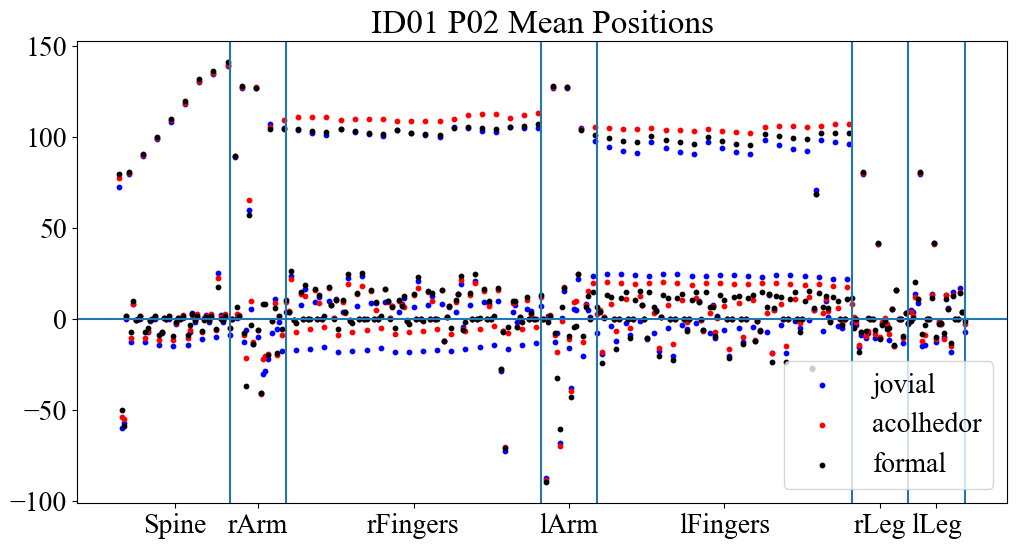

In [11]:
%matplotlib inline
to_plot = compute_means(dataset, 1,2)
fig = plt.figure(figsize=(12,6))
plt.scatter(np.arange(len(to_plot[0])), to_plot[0], s = 10, c = 'blue', label='jovial')
plt.scatter(np.arange(len(to_plot[1])), to_plot[1], s = 10, c = 'red', label='acolhedor')
plt.scatter(np.arange(len(to_plot[2])), to_plot[2], s = 10, c = 'black', label='formal')
i = np.array([48,72,180,204,312,336,360])/2
labels_xticks = np.array([i[0], i[0]+(i[1]-i[0])/2, i[1]+(i[2]-i[1])/2, i[2]+(i[3]-i[2])/2, i[3]+(i[4]-i[3])/2, i[4]+(i[5]-i[4])/2, i[5]+(i[6]-i[5])/2])
labels_name = ["Spine", "rArm", "rFingers", "lArm", "lFingers","rLeg","lLeg"]
for idx in labels_idx:
    plt.axvline(idx)
plt.axhline(0)
plt.xticks(labels_xticks, labels = labels_name)
plt.legend()
plt.title("ID01 P02 Mean Positions")

In [30]:
for k,v in dataset.joint.items():
    print(k,v)

Hips_rx 0
Hips_ry 1
Hips_rz 2
Hips_tx 3
Hips_ty 4
Hips_tz 5
Spine_rx 6
Spine_ry 7
Spine_rz 8
Spine_tx 9
Spine_ty 10
Spine_tz 11
Spine1_rx 12
Spine1_ry 13
Spine1_rz 14
Spine1_tx 15
Spine1_ty 16
Spine1_tz 17
Spine2_rx 18
Spine2_ry 19
Spine2_rz 20
Spine2_tx 21
Spine2_ty 22
Spine2_tz 23
Spine3_rx 24
Spine3_ry 25
Spine3_rz 26
Spine3_tx 27
Spine3_ty 28
Spine3_tz 29
Neck_rx 30
Neck_ry 31
Neck_rz 32
Neck_tx 33
Neck_ty 34
Neck_tz 35
Neck1_rx 36
Neck1_ry 37
Neck1_rz 38
Neck1_tx 39
Neck1_ty 40
Neck1_tz 41
Head_rx 42
Head_ry 43
Head_rz 44
Head_tx 45
Head_ty 46
Head_tz 47
RightShoulder_rx 48
RightShoulder_ry 49
RightShoulder_rz 50
RightShoulder_tx 51
RightShoulder_ty 52
RightShoulder_tz 53
RightArm_rx 54
RightArm_ry 55
RightArm_rz 56
RightArm_tx 57
RightArm_ty 58
RightArm_tz 59
RightForeArm_rx 60
RightForeArm_ry 61
RightForeArm_rz 62
RightForeArm_tx 63
RightForeArm_ty 64
RightForeArm_tz 65
RightHand_rx 66
RightHand_ry 67
RightHand_rz 68
RightHand_tx 69
RightHand_ty 70
RightHand_tz 71
RightHandMiddl

In [6]:
for i, (id, part) in enumerate([[1,1],[1,2],[2,1],[2,2]]):
    print(i,id,part)

0 1 1
1 1 2
2 2 1
3 2 2
